In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy.stats import skew
plt.rcParams.update({'font.size': 16})

In [2]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])


batchSize = 128


convergence_epoch = 6
maximum_epoch = 70


In [3]:
target = 'I3V'
inChannels = np.array(['I1V', 'I2V', 'I3V',  'I5V', 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V', 'I11H'])
itarget = np.argwhere(inChannels == target)[0][0]
#inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V', 'I11H'])

In [4]:
def quantile_loss(y_pre, y, quantiles):
    loss = 0
    for i in range(len(quantiles)):
        dy = y_pre[:, 3] - y
        qs = quantiles[i]
        l = np.where(dy >= 0.0, 
                        (1.0 - qs) * abs(dy),
                        (qs) * abs(dy))
        loss += l.mean()
    return loss.mean()  

### read data

In [5]:
from torch.utils.data import DataLoader, random_split
from ici import iciData


itarget, = np.argwhere(inChannels == target)[0]
data = iciData("TB_ICI_train.nc", 
               inChannels, target, 
               batch_size = batchSize)   
inputs = len(inChannels)

n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])
results = []


In [6]:
def train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data):
        qrnn = QRNN(inputs, quantiles, (depth, width , "relu"))
        for lr in [ 0.01, 0.001, 0.0001]:
            print ("NEW LEARNING RATE")
            results = qrnn.train(
                training_data,
                validation_data,
                batch_size=batchSize,
                momentum = 0,
                sigma_noise=None,
                initial_learning_rate= lr ,
                maximum_epochs=maximum_epoch,
                convergence_epochs= convergence_epoch,    
                gpu=True)

        return results, qrnn

### grid search for depth and width

In [7]:
nn_depths  = [ 2, 3, 4 ]
nn_widths  = [ 8, 16, 32, 64, 128, 256, 512]

In [8]:

#for nn_dep in nn_depths:
#    for nn_wid in nn_widths:
#        results, qrnn = train(nn_dep, nn_wid, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data)
#        fig, ax = plt.subplots(1, 1)
#        ax.plot(results['training_errors'])
#        ax.plot(results['validation_errors'])
#        qrnn.save('qrnn_ici_depth-%s_width-%s_%s.nc'%(str(nn_dep),str(nn_wid),target))

In [9]:

test_data = iciData("TB_ICI_train.nc", 
               inChannels, target, 
               batch_size = batchSize)  
n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])



In [10]:
y_pre = []
y = []
y_prior = []
y_pos_mean = []
x_in = []

nbatch = validation_data.__len__()
print (nbatch)
for i in range(nbatch):
    
    xx, yy = validation_data.__getitem__(i)
    
    x = xx.detach().numpy() 

    y_prior.append((x * data.std) + data.mean)
#    y_prior.append((x[:, 0]))

#    y_pre.append(qrnn.predict(x)) 
#    y_pos_mean.append((qrnn.posterior_mean(x)))
       
    y.append(yy.detach().numpy())
    x_in.append(x)
x = np.concatenate(x_in, axis = 0) 
y = np.concatenate(y, axis= 0)

118


In [11]:
scores = np.empty([len(nn_depths), len(nn_widths)])
loss = np.empty([len(nn_depths), len(nn_widths)])
quantiles1 = np.array([0.5])
for i, nn_depth in enumerate(nn_depths):
    for j, nn_width in enumerate(nn_widths):
        filename = 'qrnn_ici_depth-%s_width-%s_%s.nc'%(str(nn_depth),str(nn_width),target)
        print(filename)
        qrnn = QRNN.load(filename)

        y_pre = qrnn.predict(x)
        y0 = y
#        scores = qrnn.crps(y_pre, y, quantiles)
        scores[i,j] = np.mean(qrnn.crps(y_pre, y0, quantiles))
    
        loss[i,j] = quantile_loss(y_pre, y0, quantiles)


qrnn_ici_depth-2_width-8_I3V.nc
qrnn_ici_depth-2_width-16_I3V.nc
qrnn_ici_depth-2_width-32_I3V.nc
qrnn_ici_depth-2_width-64_I3V.nc
qrnn_ici_depth-2_width-128_I3V.nc
qrnn_ici_depth-2_width-256_I3V.nc
qrnn_ici_depth-2_width-512_I3V.nc
qrnn_ici_depth-3_width-8_I3V.nc
qrnn_ici_depth-3_width-16_I3V.nc
qrnn_ici_depth-3_width-32_I3V.nc
qrnn_ici_depth-3_width-64_I3V.nc
qrnn_ici_depth-3_width-128_I3V.nc
qrnn_ici_depth-3_width-256_I3V.nc
qrnn_ici_depth-3_width-512_I3V.nc
qrnn_ici_depth-4_width-8_I3V.nc
qrnn_ici_depth-4_width-16_I3V.nc
qrnn_ici_depth-4_width-32_I3V.nc
qrnn_ici_depth-4_width-64_I3V.nc
qrnn_ici_depth-4_width-128_I3V.nc
qrnn_ici_depth-4_width-256_I3V.nc
qrnn_ici_depth-4_width-512_I3V.nc


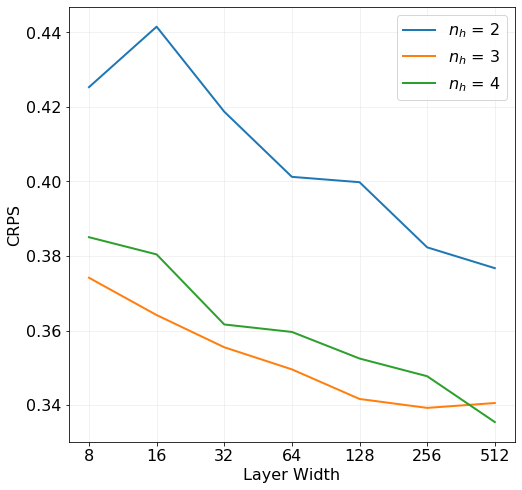

In [12]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
for i in range(len(nn_depths)):
    ax.plot(scores[i, :], linewidth = 2)
ax.set_xlabel("Layer Width")
ax.set_ylabel("CRPS")
ax.set_xticks(np.arange(len(nn_widths)))
ax.set_xticklabels(nn_widths)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.2)
#ax.set_yscale('log')
ax.legend(["$n_h$ = 2", "$n_h$ = 3", "$n_h$ = 4", "$n_h$ = 4"])
fig.savefig("Figures/CRPS.png")
  



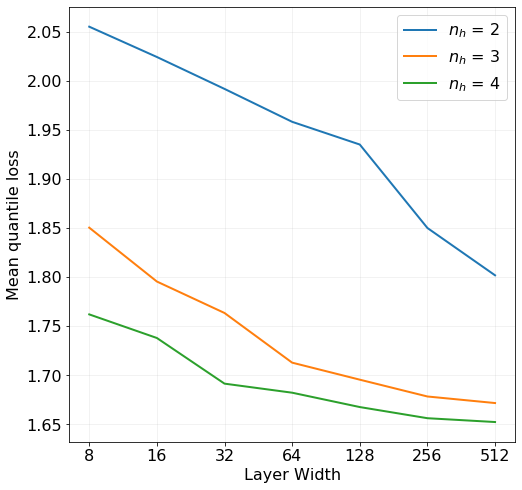

In [13]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
for i in range(len(nn_depths)):
    ax.plot(loss[i, :], linewidth = 2)
ax.set_xlabel("Layer Width")
ax.set_ylabel("Mean quantile loss")
ax.set_xticks(np.arange(len(nn_widths)))
ax.set_xticklabels(nn_widths)

ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.grid(which = 'both', alpha = 0.2)
#ax.set_yscale('log')
ax.legend(["$n_h$ = 2", "$n_h$ = 3", "$n_h$ = 4", "$n_h$ = 4"])
fig.savefig("Figures/quantile_loss.png")

In [14]:
f


NameError: name 'f' is not defined